In [1]:
import plotly
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

import pickle



import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import pickle
import geopandas as gpd

import nltk
from nltk.corpus import stopwords
import re

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

import multiprocessing 
from multiprocessing import Pool

In [ ]:
#open kp keyword assigned tweets
with open('FINAL_kp_assigned_tweets.pickle', "rb") as f:
    tweets = pickle.load(f)

In [ ]:
#open all kp tweets
with open('FINAL_KP_TWEETS_NO_2019_BOTS.pickle', "rb") as f:
    total_tweets = pickle.load(f)

In [ ]:
#Create a series of total tweets count in KP since 2018
tweets = tweets.reset_index()
tweets["index"].describe()
total_tweets["total_count"] = 1
total_tweets_count = total_tweets[["index", "total_count"]]
total_tweets_count = total_tweets_count.set_index("index")
total_tweets_count = total_tweets_count.resample("M").count()
total_tweets_count.head()
total_tweets_count = total_tweets_count["2018-01-05":"2020-03-05"]


In [ ]:
#Create a series of categorized tweets count in KP since 2018
tweets["total_count"] = 1

In [ ]:
#Update sub categories as needed and save
idp = tweets[tweets["topic_displaced_persons"]==1]
idp["topic_security_forces_extremism_violence"] = 1
violence = tweets[tweets["topic_security_forces_extremism_violence"]==1]
violence = idp.merge(violence, left_index=True, right_index=True)

with open("FINAL_kp_security_forces_extremism_violence_tweets.pickle", "wb") as f:
    pickle.dump(violence, f)

In [35]:
#Create dataframe of each sub category count over time merged with total tweet count
by_datetime = tweets[["index", "topic_elections", "topic_fata_merger", "topic_rights_and_activism", "topic_rule_of_law", "topic_security_forces_extremism_violence", "topic_service_delivery", "topic_youth"]]
by_datetime = by_datetime.set_index("index")
by_datetime = by_datetime.resample("M").count()
by_datetime = by_datetime.merge(total_tweets_count, left_index=True, right_index=True)

In [93]:
#Calculate percent of each sub category
by_datetime["elections_percent"] = (by_datetime["topic_elections"]/by_datetime["total_count"])*100
by_datetime["fata_merger_percent"] = (by_datetime["topic_fata_merger"]/by_datetime["total_count"])*100
by_datetime["rule_of_law_percent"] = (by_datetime["topic_rule_of_law"]/by_datetime["total_count"])*100
by_datetime["violent_conflict_percent"] = (by_datetime["topic_security_forces_extremism_violence"]/by_datetime["total_count"])*100
by_datetime["service_delivery_percent"] = (by_datetime["topic_service_delivery"]/by_datetime["total_count"])*100
by_datetime["rights_and_activism_percent"] = (by_datetime["topic_rights_and_activism"]/by_datetime["total_count"])*100
by_datetime["youth_percent"] = (by_datetime["topic_youth"]/by_datetime["total_count"])*100

In [96]:
#Save percents only in new dataframe
by_datetime_percent = by_datetime[["elections_percent", "fata_merger_percent", "rule_of_law_percent", "violent_conflict_percent", "service_delivery_percent", "rights_and_activism_percent", "youth_percent"]]

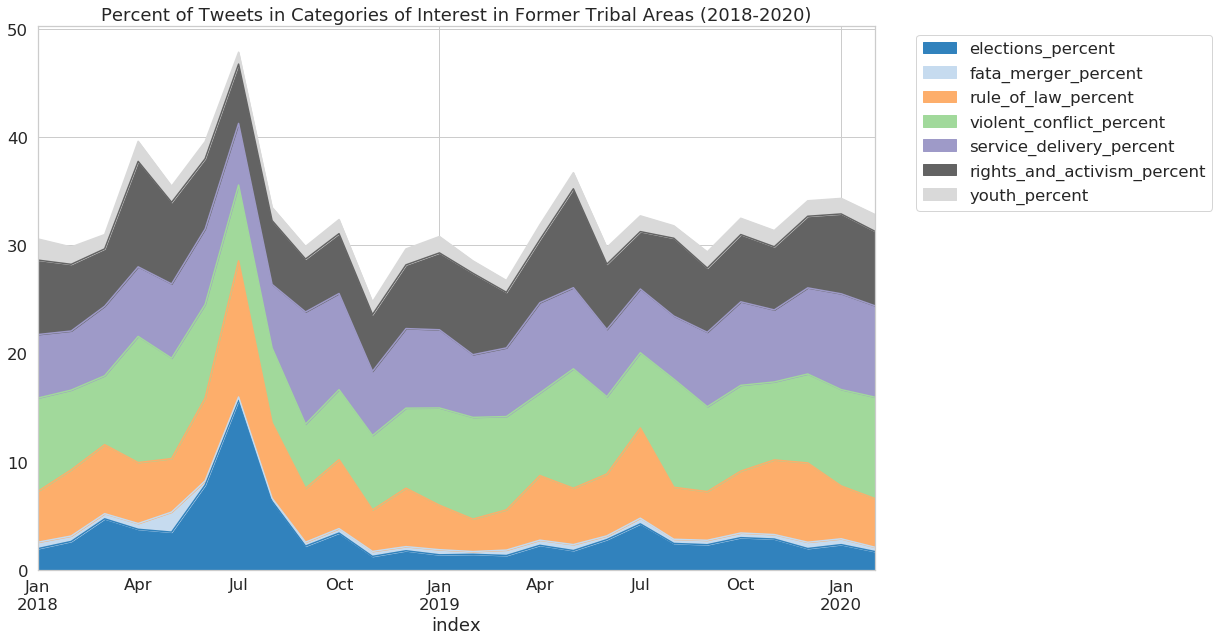

In [100]:
#Plot percents of each subcategory over time
plt.get_cmap(name="tab20c", lut=None)
by_datetime_percent.plot.area(figsize = [15,10], title="Percent of Tweets in Categories of Interest in Former Tribal Areas (2018-2020)", colormap="tab20c")

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.savefig("Percent of Tweets in Categories of Interest in Former Tribal Areas (2018-2020)", dpi=300, bbox_inches ="tight", transparent=True)

In [101]:
#Create empty column for subcategory names
tweets["category"] = np.nan

In [ ]:
#Add each subcategory name to the empty column per tweet

In [104]:
tweets.loc[tweets.topic_elections == 1, "category"] = "elections"

In [105]:
tweets.loc[tweets.topic_fata_merger == 1, "category"] = "fata_merger"

In [106]:
tweets.loc[tweets.topic_rule_of_law == 1, "category"] = "rule_of_law"

In [107]:
tweets.loc[tweets.topic_security_forces_extremism_violence ==1, "category"] = "violent_conflict"

In [108]:
tweets.loc[tweets.topic_service_delivery ==1, "category"] = "service_delivery"

In [109]:
tweets.loc[tweets.topic_youth == 1, "category"] = "youth"

In [110]:
tweets.loc[tweets.topic_rights_and_activism == 1, "category"] = "rights_and_activism"

In [111]:
#Get the sum of value counts of each sub-topic of tweets and find its relative percent to the total in the topic
percents = tweets[tweets["hedonometer"]!=0]
percents = percents["category"].value_counts()
percents = pd.DataFrame(percents)
percents.sum()

category    1241189
dtype: int64

In [112]:
#Save as a dataframe with sub topics and their percents
percents["percent"] = percents["category"].apply(lambda x: (x/1241189)*100)
percents = percents.reset_index()
percents.columns = ["category", "count", "percent"]
percents = percents[["category", "percent"]]

In [114]:
#Create a dataframe of tweets in this topic with sentiment not equal to zero and sub topic not equal to None
sent = tweets[tweets["hedonometer"] != 0]
sent = sent[sent["category"] != "None"]

In [115]:
#Define the median point for sentiment in the kp dataset and assign tweets from sentiment dataframe to low or high
low_sentiment = sent[sent["hedonometer"] <= 5.49]
high_sentiment = sent[sent["hedonometer"] > 5.49]

In [116]:
#Create a count of low sentiment tweets by sub topic and merge with the percent of the sub topic in the topic dataframe and generate a count of all low-sentiment tweets

low_sentiment["count"] = 1
low_sentiment = low_sentiment[["category", "count"]]
low_sentiment = low_sentiment.groupby(["category"]).sum()
low_sentiment = low_sentiment.reset_index()

low_sentiment = low_sentiment.merge(percents, left_on = "category", right_on = "category")

low_sentiment["count"].sum()


724694

In [117]:
#Calculate the percent difference for each low sentiment sub category compared to the median for the data and sort values
for i, row in low_sentiment.iterrows():
    low_sentiment.at[i,'low_percent'] = (low_sentiment.at[i,'count'] / 724694)*100

low_sentiment["percent_difference"] = low_sentiment["low_percent"] - low_sentiment["percent"]

low_sentiment_plot = low_sentiment[low_sentiment["percent_difference"]>0]

low_sentiment_plot = low_sentiment_plot.set_index("category")
low_sentiment_plot = low_sentiment_plot[["percent_difference"]]
low_sentiment_plot = low_sentiment_plot.sort_values(by='percent_difference', ascending=False)


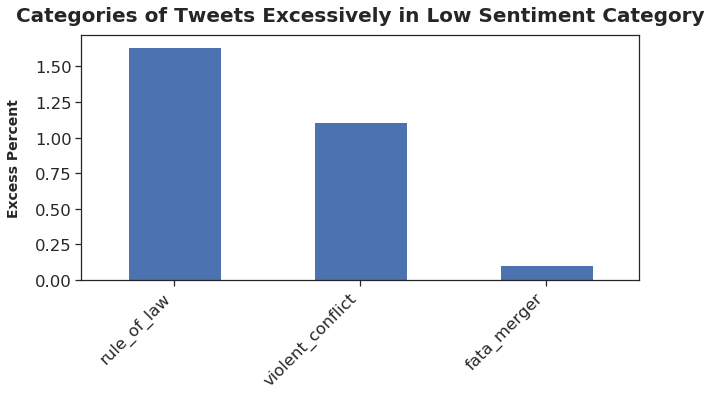

In [118]:
#Plot low sentiment categories
with sns.axes_style("white"):
    sns.set_style("ticks")

    fig,ax = plt.subplots(figsize=(10,5))
    data_to_plot=low_sentiment_plot
    data_to_plot.plot(ax=ax,kind='bar')
    ax.set_ylabel('Excess Percent',fontweight='bold', labelpad = 14, fontsize = 14)
    ax.set_xlabel('',fontweight='bold', labelpad = 14, fontsize = 14)
    ax.tick_params(which='y',direction='in',pad=3)
    ax.tick_params(which='x', labelsize=16, pad=3)
    fig.autofmt_xdate(rotation=45)
    ax.set_title("Categories of Tweets Excessively in Low Sentiment Category", pad = 14, fontweight="bold", fontsize=20)
    ax.get_legend().remove()
    
plt.savefig("Excess Percent of Tweets in Low Sentiment Category KP Topics of Interest", dpi=300, bbox_inches ="tight", transparent = True)

In [119]:
#Create a count of high sentiment tweets by sub topic and merge with the percent of the sub topic in the topic dataframe and generate a count of all high-sentiment tweets
high_sentiment["count"] = 1
high_sentiment = high_sentiment[["category", "count"]]
high_sentiment = high_sentiment.groupby(["category"]).sum()
high_sentiment = high_sentiment.reset_index()

high_sentiment = high_sentiment.merge(percents, left_on = "category", right_on = "category")

high_sentiment["count"].sum()

516495

In [120]:
#Calculate the percent difference for each high sentiment sub category compared to the median for the data and sort values
for i, row in high_sentiment.iterrows():
    high_sentiment.at[i,'high_percent'] = (high_sentiment.at[i,'count'] / 516495)*100

high_sentiment["percent_difference"] = high_sentiment["high_percent"] - high_sentiment["percent"]

high_sentiment_plot = high_sentiment[high_sentiment["percent_difference"]>0]

high_sentiment_plot = high_sentiment_plot.set_index("category")
high_sentiment_plot = high_sentiment_plot[["percent_difference"]]
high_sentiment_plot = high_sentiment_plot.sort_values(by='percent_difference', ascending=False)


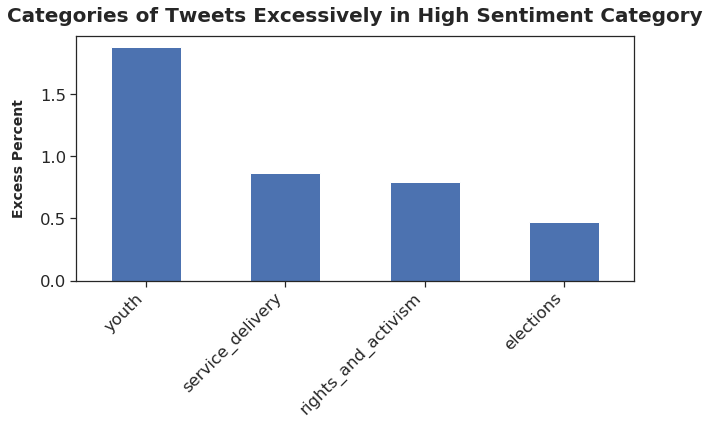

In [121]:
#Plot high sentiment categories
with sns.axes_style("white"):
    sns.set_style("ticks")

    fig,ax = plt.subplots(figsize=(10,5))
    data_to_plot=high_sentiment_plot
    data_to_plot.plot(ax=ax,kind='bar')
    ax.set_ylabel('Excess Percent',fontweight='bold', labelpad = 14, fontsize = 14)
    ax.set_xlabel('',fontweight='bold', labelpad = 14, fontsize = 16)
    ax.tick_params(which='y',direction='in',pad=3)
    ax.tick_params(which='x', labelsize=16, pad=3)
    fig.autofmt_xdate(rotation=45)
    ax.set_title("Categories of Tweets Excessively in High Sentiment Category", pad = 14, fontweight="bold", fontsize=20)
    ax.get_legend().remove()
    
plt.savefig("Excess Percent of Tweets in High Sentiment Category KP Topics of Interest", dpi=300, bbox_inches ="tight", transparent = True)

In [122]:
pd.set_option('display.max_colwidth', -1)

In [47]:
#Create a sorted list of Bigrams

#First put all words of all tweets in a list and remove stopwords
all_tweets = tweets['clean_translation'].to_list()

words_in_tweet = [tweet.split() for tweet in all_tweets]
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigram_counts.most_common(),
                             columns=['bigram', 'count'])
bigram_df["string"] = bigram_df["bigram"].apply(lambda x: str(x))
bigram_df["words"] = bigram_df["string"].str.replace('[^\w\s]','')

[nltk_data] Downloading package stopwords to /home/dval/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


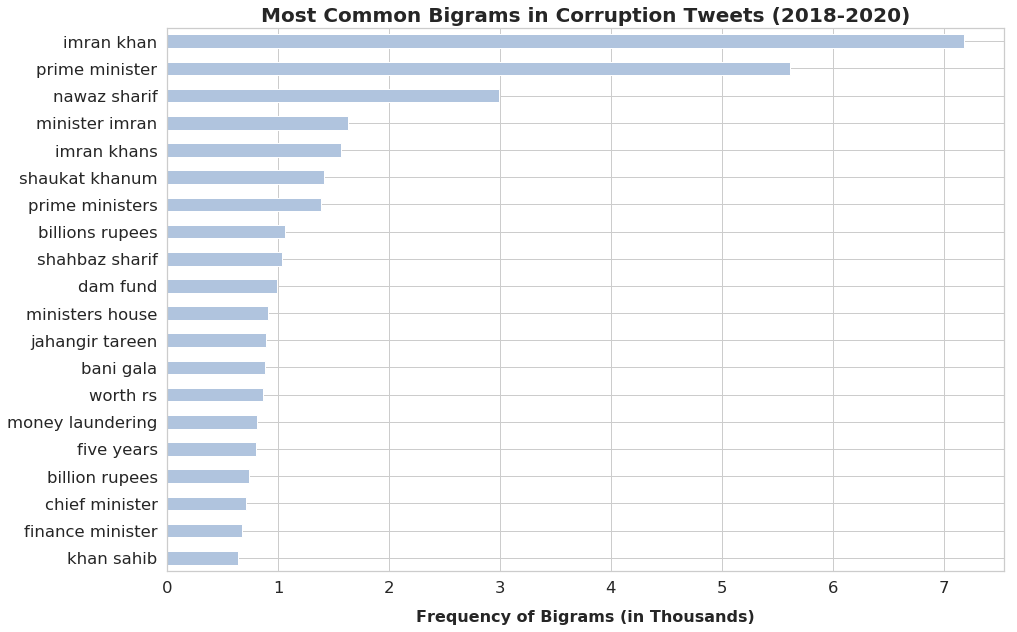

In [49]:
#Plot top bigrams in the topic
bigram_df["count"] = bigram_df["count"]/1000

#Bigrams View
bigram_df = bigram_df.head(20)

#Bigram Plot

fig, ax = plt.subplots(figsize=(15, 10))

# Plot horizontal bar graph
bigram_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="lightsteelblue")

ax.set_title("Most Common Bigrams in Corruption Tweets (2018-2020)", fontweight="bold", fontsize=20)
ax.set_ylabel('',fontweight='bold', labelpad = 14, fontsize = 16)
ax.set_xlabel('Frequency of Bigrams (in Thousands)',fontweight='bold', labelpad = 14, fontsize = 16)
ax.get_legend().remove()
    

plt.savefig("Most Common Bigrams in Corruption Tweets (2018-2020).pdf", dpi=300, bbox_inches ="tight")

In [83]:
#Create a list of word counts in the topic

#First put all words in all tweets into a listall_tweets = tweets['clean_translation'].to_list()
words_in_tweet = [tweet.split() for tweet in all_tweets]
all_words = list(itertools.chain(*words_in_tweet))

# Create counter
counts = collections.Counter(all_words)
stop_words = nltk.corpus.stopwords.words('english')
stop_words.append("amp")
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]
all_words_nsw = list(itertools.chain(*tweets_nsw))
counts_nsw = collections.Counter(all_words_nsw)

#Return dataframe
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(20),
                             columns=['words', 'count'])

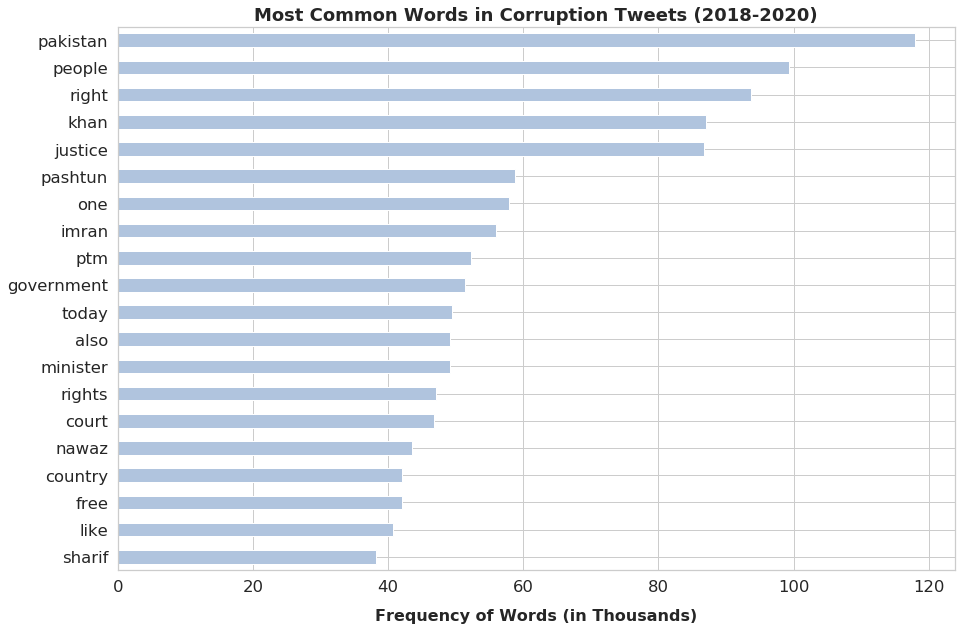

In [84]:
#Plot most frequent words in this topic
clean_tweets_nsw["count"] = clean_tweets_nsw["count"]/1000

fig, ax = plt.subplots(figsize=(15, 10))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="lightsteelblue")

ax.set_title("Most Common Words in Corruption Tweets (2018-2020)", fontweight="bold", fontsize=18)
ax.set_ylabel('',fontweight='bold', labelpad = 14, fontsize = 16)
ax.set_xlabel('Frequency of Words (in Thousands)',fontweight='bold', labelpad = 14, fontsize = 16)
ax.get_legend().remove()
    

#plt.savefig("Most Common Words in Corruption Tweets (2018-2020).pdf", dpi=300, bbox_inches ="tight", transparent=True)

In [54]:
#Plot most frequent hashtags in this topic

#first grab hashtags from the dataset and drop empty fields
hashtags = tweets[["hashtags"]]
hashtags = hashtags.dropna()

#Define function to split the sub-lists of hashtags for each tweet and to parallelize the process over multiple cores
def hashtags_only(data):
    return pd.Series(data["hashtags"].str.split(', ').sum()).value_counts()

def parallelize_dataframe(df, func, n_cores=30):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

#Calculate hashtag frequencies and turn into dataframe for plotting
hashtag_frequencies = parallelize_dataframe(hashtags, hashtags_only)
hashtag_df = pd.DataFrame(hashtag_frequencies)
hashtag_df = hashtag_df.reset_index()
hashtag_df.columns = ["hashtag", "count"]
hashtag_plot = hashtag_df.head(20)

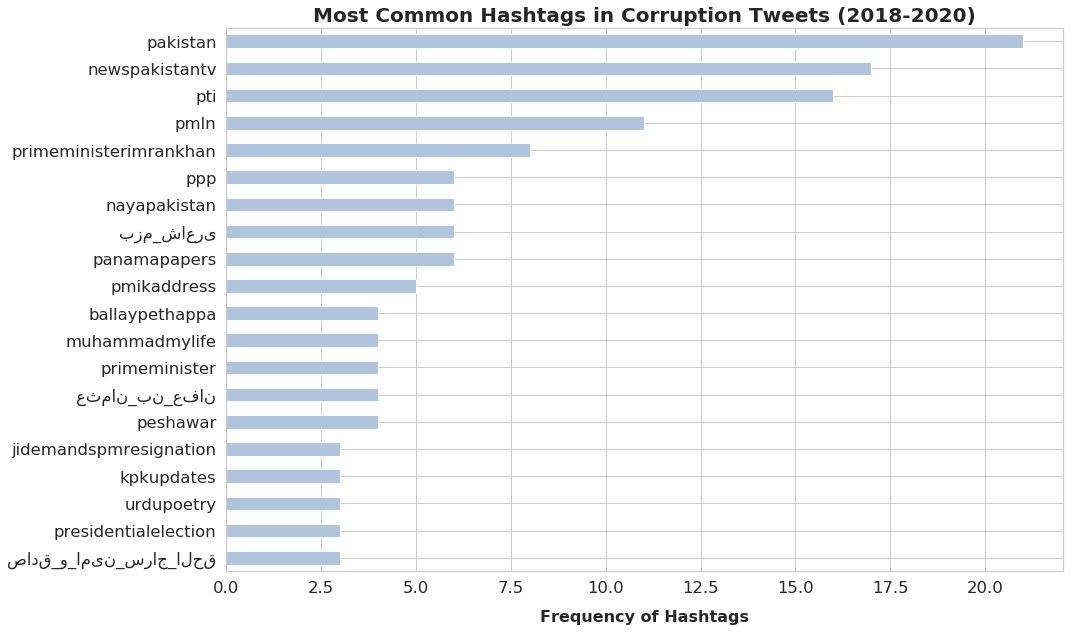

In [55]:
#Plot most frequent hashtags
fig, ax = plt.subplots(figsize=(15, 10))

# Plot horizontal bar graph
hashtag_plot.sort_values(by='count').plot.barh(x='hashtag',
                      y='count',
                      ax=ax,
                      color="lightsteelblue")

ax.set_title("Most Common Hashtags in Corruption Tweets (2018-2020)", fontweight="bold", fontsize=20)
ax.set_ylabel('',fontweight='bold', labelpad = 14, fontsize = 16)
ax.set_xlabel('Frequency of Hashtags',fontweight='bold', labelpad = 14, fontsize = 16)
ax.get_legend().remove()
    

plt.savefig("Most Common Hashtags in Corruption Tweets (2018-2020).pdf", dpi=300, bbox_inches ="tight")

In [56]:
#Define the cetroid for the shapes in shapefile
pakistan["center"] = pakistan["geometry"].centroid
pakistan_points = pakistan.copy()
pakistan_points.set_geometry("center", inplace = True)

In [57]:
#define number of unique users per location in this topic
location = tweets[["user_id", "user_location"]]
location = location.groupby("user_location").nunique()
location = location.drop(columns=["user_location"])

#define number of unique users per location across all tweets
location_all = total_tweets[["user_id", "user_location"]]
location_all = location_all.groupby("user_location").nunique()
location_all = location_all.drop(columns=["user_location"])

#merge datasets and determine the percent of unique users per location tweeting about this topic
location = location_all.merge(location, left_index = True, right_index = True)
location.columns = ["total", "subset"]

location["percent"] = (location["subset"] / location["total"]) * 100

#read in the shapefile with lowercase place names 
pakistan = gpd.read_file('PAK_adm3.shp')
pakistan = pakistan[["NAME_3", "geometry"]]
pakistan["NAME_3"] = pakistan["NAME_3"].str.lower()

#merge percent of users with shapefile to plot
plot = pakistan.merge(location, how='left', left_on="NAME_3", right_on="user_location")

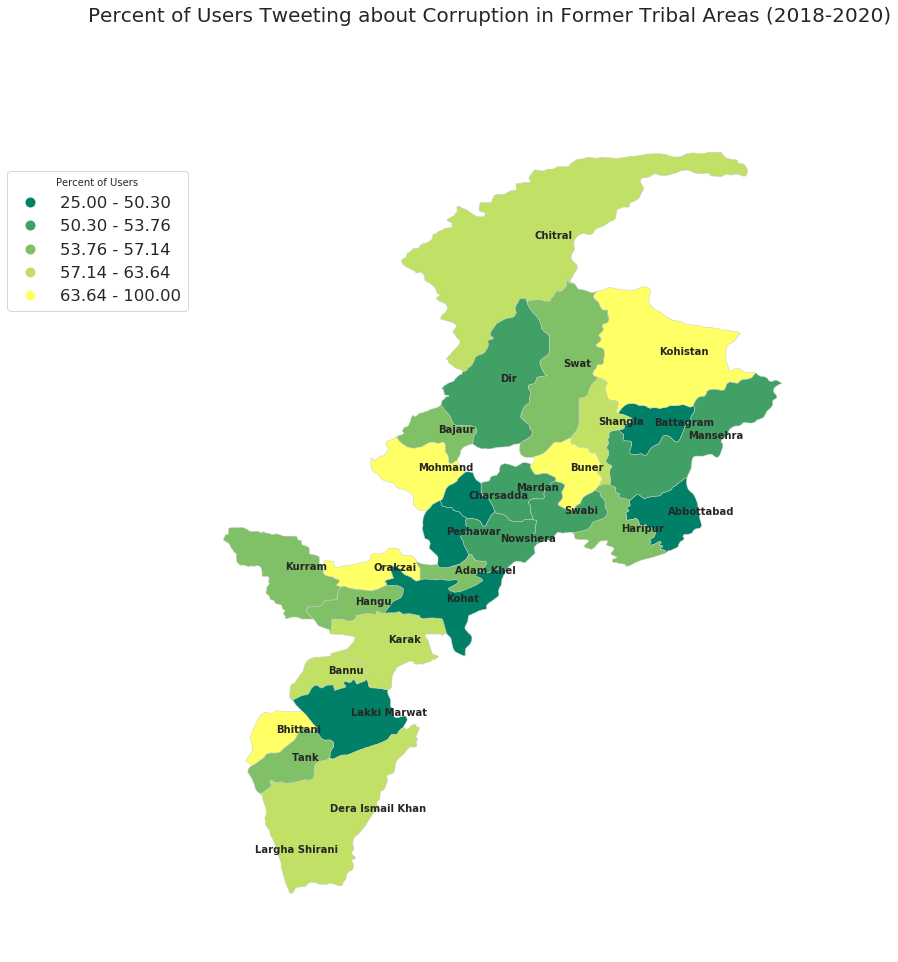

In [58]:
#Plot percent of users tweeting about this topic on map with place names at center
with sns.axes_style("white"):
    sns.set_style("ticks")
    
    fig,ax = plt.subplots(figsize=(15,15))

    data_to_plot=plot[['percent','geometry']].copy()

    fig.suptitle('Percent of Users Tweeting about Corruption in Former Tribal Areas (2018-2020)', fontsize = 20)
    
    texts=[]
    for x, y, label in zip(pakistan_points.geometry.x, pakistan_points.geometry.y, pakistan_points["NAME_3"]):
        texts.append(plt.text(x, y, label, fontsize = 10, fontweight="bold"))
        
    data_to_plot.plot(
    'percent',
    scheme='Quantiles',
    linewidth=0.5, 
    k=5,
    ax=ax, 
    cmap='summer',
    edgecolor='0.8',
    legend="Full",
    legend_kwds={
    'frameon': True, 
    'title': 'Percent of Users',
    'loc': 'lower right',
    'bbox_to_anchor':(0.0002,0.75), 
    'frameon':'False',
    })
    ax.axis('off')
    
    plt.savefig("Percent of Users Tweeting about Corruption in Former Tribal Areas (2018-2020)).pdf", dpi=300, bbox_inches ="tight", transparent = True)

In [123]:
#Create a dataframe with the number of unique users per location 
users = total_tweets[["user_id", "user_location"]]
users = users.groupby(["user_location"]).agg({"user_id":"nunique"})

In [124]:
#Create a dataframe for each sub-topic with number of unique users tweeting about that subtopic divided by the number of unique users in that place to determine percent of users tweeting about the sub-topic.

In [125]:
service_delivery = tweets[tweets["category"] == "service_delivery"]
service_delivery = service_delivery[["user_id", "user_location"]]
service_delivery = service_delivery.groupby(['user_location']).agg({'user_id': "nunique"})
service_delivery = service_delivery["user_id"] / users["user_id"] * 100
service_delivery = pd.DataFrame(service_delivery)
service_delivery.columns = ["service_delivery"]







In [126]:
rights_and_activism = tweets[tweets["category"] == "rights_and_activism"]
rights_and_activism = rights_and_activism[["user_id", "user_location"]]
rights_and_activism = rights_and_activism.groupby(['user_location']).agg({'user_id': "nunique"})
rights_and_activism = rights_and_activism["user_id"] / users["user_id"] * 100
rights_and_activism = pd.DataFrame(rights_and_activism)
rights_and_activism.columns = ["rights_and_activism"]






In [127]:
security_forces_extremism_violence = tweets[tweets["category"] == "security_forces_extremism_violence"]
security_forces_extremism_violence = security_forces_extremism_violence[["user_id", "user_location"]]
security_forces_extremism_violence = security_forces_extremism_violence.groupby(['user_location']).agg({'user_id': "nunique"})
security_forces_extremism_violence = security_forces_extremism_violence["user_id"] / users["user_id"] * 100
security_forces_extremism_violence = pd.DataFrame(security_forces_extremism_violence)
security_forces_extremism_violence.columns = ["security_forces_extremism_violence"]






In [128]:
fata_merger = tweets[tweets["category"] == "fata_merger"]
fata_merger = fata_merger[["user_id", "user_location"]]
fata_merger = fata_merger.groupby(['user_location']).agg({'user_id': "nunique"})
fata_merger = fata_merger["user_id"] / users["user_id"] * 100
fata_merger = pd.DataFrame(fata_merger)
fata_merger.columns = ["fata_merger"]








In [129]:
rule_of_law = tweets[tweets["category"] == "rule_of_law"]
rule_of_law = rule_of_law[["user_id", "user_location"]]
rule_of_law = rule_of_law.groupby(['user_location']).agg({'user_id': "nunique"})
rule_of_law = rule_of_law["user_id"] / users["user_id"] * 100
rule_of_law = pd.DataFrame(rule_of_law)
rule_of_law.columns = ["rule_of_law"]




In [130]:
youth = tweets[tweets["category"] == "youth"]
youth = youth[["user_id", "user_location"]]
youth = youth.groupby(['user_location']).agg({'user_id': "nunique"})
youth = youth["user_id"] / users["user_id"] * 100
youth = pd.DataFrame(youth)
youth.columns = ["youth"]






In [131]:
elections = tweets[tweets["category"] == "elections"]
elections = elections[["user_id", "user_location"]]
elections = elections.groupby(['user_location']).agg({'user_id': "nunique"})
elections = elections["user_id"] / users["user_id"] * 100
elections = pd.DataFrame(elections)
elections.columns = ["elections"]


In [132]:
#Merge all subtopic dataframes

one = service_delivery.merge(rights_and_activism, left_index=True, right_index = True)
two = security_forces_extremism_violence.merge(fata_merger, left_index=True, right_index=True)
three = rule_of_law.merge(youth, left_index=True, right_index=True)
four = elections

one = one.merge(two, left_index=True, right_index=True)
two = three.merge(four, left_index=True, right_index=True)
df_plot = one.merge(two, left_index=True, right_index=True)


In [135]:
#Sort places by the sum total of the unique users tweeting about each sub topic for plotting
df_plot["sum"] = df_plot.sum(axis=1)
df_plot = df_plot.sort_values("sum", ascending=False)
df_plot = df_plot.drop(columns=["sum"])

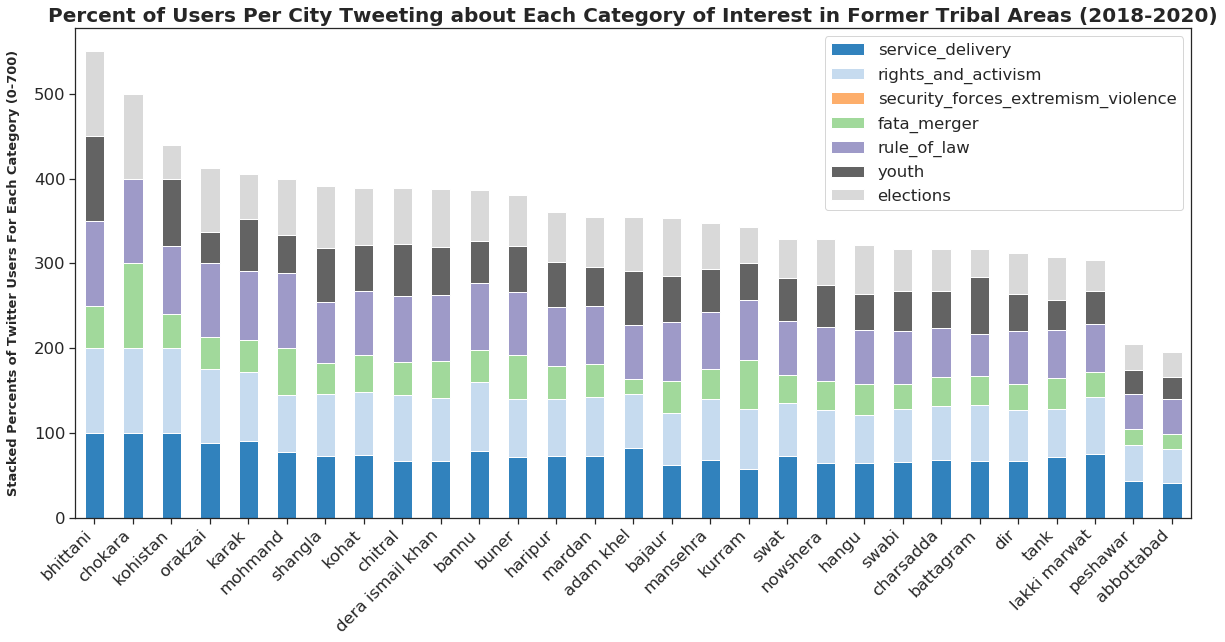

In [139]:
#Plot percent of unique users tweeting about each sub-topic per location
with sns.axes_style("white"):
    sns.set_style("ticks")

    fig,ax = plt.subplots(figsize=(20,10))
    data_to_plot=df_plot
    data_to_plot.plot(ax=ax,kind='bar', stacked=True, colormap="tab20c")
    ax.set_ylabel('Stacked Percents of Twitter Users For Each Category (0-700)',fontweight='bold', labelpad = 14, fontsize = 13)
    ax.set_xlabel('',fontweight='bold', labelpad = 14, fontsize = 20)
    ax.tick_params(which='y',direction='in',pad=3)
    ax.tick_params(which='x', labelsize=16, pad=3)
    fig.autofmt_xdate(rotation=45)
    ax.set_title("Percent of Users Per City Tweeting about Each Category of Interest in Former Tribal Areas (2018-2020)", fontweight="bold", fontsize=20)
    
    plt.savefig("Percent of Users Per City Tweeting about Each Category of Interest in Former Tribal Areas (2018-2020)", dpi=300, bbox_inches ="tight")